References Credits: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

In [ ]:
# Import relevant packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter

# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import matplotlib.pyplot as plt
import methods_py as m
import re
import sys,time

# reload to make sure we have the latest version of method.py loaded
import importlib
importlib.reload(m)

# NLTK package for stopwords
import nltk
nltk.download(['punkt', 'wordnet','stopwords'])
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# sklearn 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, plot_precision_recall_curve, roc_auc_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# Read in the train data 
df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
# display the first 5 rows
df.head()

## 1. Explore the dataframe

In [ ]:
# call custom method to explore the dataframe
m.explore_df(df)

In [ ]:
# list of columns for the labelled comment type 
df.drop(['id','comment_text'],axis=1).columns

In [ ]:
# adding some of the ad-hoc words coming up as frequent and I want to exclude those
stop_words.update(["u","go","as","like","wikipedia","jim","hi","get"])

# tokeinze method to remove punctuations, lemmatize and remove stop words
def tokenize(text):
    '''
    INPUT
    text- the text that needs to be tokenized
    
    OUTPUT
    tokens - a list of tokenized words after cleaning up the input text
    
    This function :
    1. converts text to all lower case and removes punctuations
    2. tokenize entire text into words
    2. lemmatize each word using WordNetLemmatizer
    3. remove all stop words from text as per english corpus of stop words
    '''
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    # initiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    # lemmatize and remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stop_words]
    
    return tokens

In [ ]:
print(" ###### WARNING : Comments below contain strong profanity and abusive words ####### \n")

# utilizing counter to get the most common 10 words coming up in each category
for category in list(df.drop(['id','comment_text'],axis=1).columns):
    print("10 most frequent words in "+category+" comments")
    print(dict(Counter(tokenize(" ".join(df[df[category]==1].comment_text))).most_common(10)).keys())
    print("\n ********************* \n")

In [ ]:
# access custom method to explore dataframe
m.explore_null(df)

In [ ]:
# Lets explore the number of comments for each category
# This gives us a quick view of how the dataset is populated

df_toxic = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])

df_stats.plot(x='category', y='number_of_comments', kind='barh', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

In [ ]:
# How many comments have multi labels?

df.drop(['id','comment_text'],axis=1).sum(axis=1).value_counts().plot(kind='bar')
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [ ]:
# % of comments which are labeled

round((sum(df.drop(['id','comment_text'],axis=1).sum(axis=1) > 0)/len(df))*100,2)

Observation : This is an imbalanced set with almost 90% of comments not classified into any one of the 6 categories

In [ ]:
#The distribution of the number of words in comment texts.

lens = df.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50))

plt.ylabel('# of occurences', fontsize=12)
plt.xlabel('# of words', fontsize=12)

## 2. Modeling : We work with a Linear SVC Model

#### We evaluate three different classification models later towards the end : LinearSVC, NaiveBayes and Logistic Regression 

In [ ]:
# Credits: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
#          https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
#          https://scikit-learn.org/stable/modules/multiclass.html
        
def build_model(model_type, c):
    '''
    INPUT
    model type - which model we want to build between Linear SVC, NaiveBayes and Logistic Regression
    
    OUTPUT
    pipeline- a pipeline built to vectorize, tokenize, transform and classify text data
    
    This function :
    1. builds a pipeline of countvectorizer, tfidf transformer, and
    2. a random forest multi output classifier
    '''
    #check the model_type provided by user
    if model_type == 'linear_svc':
        pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LinearSVC(C=c), n_jobs=3))
    ])
        
    #check the model_type provided by user    
    elif model_type== 'naivebayes':
        pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))
    ])
        
    #check the model_type provided by user    
    elif model_type== 'logistic_reg':
        pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1))
    ])
        
    #check the model_type provided by user    
    elif model_type== 'random_forest':
        pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(RandomForestClassifier(max_depth=2, random_state=0), n_jobs=1))
    ])
        
    #check the model_type provided by user    
    elif model_type== 'decision_tree':
        pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(DecisionTreeClassifier(random_state=0), n_jobs=1))
    ])
    
    # return the built pipeline
    return pipeline

Credits: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

We consider using the ROC AUC score for evaluation the model as it is an imbalanced dataset with around 90% of comments with no labels i.e. clean comments

***Although widely used, the ROC AUC is not without problems.***

For imbalanced classification with a severe skew and few examples of the minority class, the ROC AUC can be misleading. This is because a small number of correct or incorrect predictions can result in a large change in the ROC Curve or ROC AUC score.

A common alternative is the precision-recall curve and area under curve (Precision-Recall Curves and AUC)


## 3. Predict and evaluate models

In [ ]:
def evaluate_model(model, X_test, Y_test):
    '''
    INPUT
    model : the model that needs to be evaluated
    X_test : validation data set i.e. messages in this case
    Y_test : the output data for X_test validation set i.e. 36 categories values
    category_names : the 36 category names
    
    OUTPUT
    classification report for the model based on predictions, gives
    the recall, precision and f1 score
    
    This function :
    1. utilizes the input model to make predictions
    2. compares the predictions to the test data to provide a classification report
    '''
    
    y_pred = model.predict(X_test)
    
    # ROC AUC Score
    return round(roc_auc_score(Y_test, y_pred),3)
    

Based on our comparisons between NaiveBayes , Logistic Regression and Linear SVC Model 

we consider utilizing the Linear SVC Model for our classification


In [ ]:
model_type = 'linear_svc'

# we will be using each one of the category below to utilize them as the Predicted value (Y)
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# we will utilize the comment text column to predict Y
X= df['comment_text']

print("Training with a "+model_type+" model")


Credits: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769

In [ ]:
model_dict= dict()

for category in categories:

    print(" ---------------------------------------- ")
    #print(" Working on evaluating ROC AUC score for "+category+" comments ............")
    
    # the category becomes our predicted variable
    Y= df[category]
    
    # split the data set to a train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    
    tmp_score = 0
    
    for C in [0.1,1,10]:
        
        print('Building model for ',category,' comments for C=',C,'...')
        model = build_model(model_type,C)
        
        print('Training model...')
        start_time = time.time()
        model.fit(X_train, Y_train)
        elapsed_time = round((time.time() - start_time)/60 , 2)
        print('Training time...{} minutes'.format(elapsed_time))

        print('Evaluating model...')
        print("ROC AUC Score: ",evaluate_model(model, X_test, Y_test))
        
        if evaluate_model(model, X_test, Y_test) > tmp_score:
            
            #assign the latest evaluation score to tmp_score
            tmp_score = evaluate_model(model, X_test, Y_test)
            #assign this model to the tmp_model
            tmp_model = model
            
    #save the model into a dictionary
    model_dict[tmp_model] = category
    print("Model saved for ",category," comments with the highest score of ",tmp_score)
    

Comparing classifiers : https://www.cnblogs.com/yymn/p/4518016.html

In [ ]:
model_type = 'decision_tree'

print("Training with a "+model_type+" model")

model_dict_dt= dict()

for category in categories:

    print(" ---------------------------------------- ")
    #print(" Working on evaluating ROC AUC score for "+category+" comments ............")
    
    # the category becomes our predicted variable
    Y= df[category]
    
    # split the data set to a train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
      
    print('Building model for ',category,' comments')
    model = build_model(model_type,1)

    print('Training model...')
    start_time = time.time()
    model.fit(X_train, Y_train)
    elapsed_time = round((time.time() - start_time)/60 , 2)
    print('Training time...{} minutes'.format(elapsed_time))

    print('Evaluating model...')
    print("ROC AUC Score: ",evaluate_model(model, X_test, Y_test))
            
    #save the model into a dictionary
    model_dict_dt[model] = category
    print("Model saved for ",category," comments")
    

### Model Observation
Very interesting to see that for toxic comments, 
the Linear SVC is able to generate ROC AUC Score of 0.843 in 2.45 minutes  
vs 
Decision tree classifier generating ROC AUC Score of 0.835 in 13.6 minutes

IMPORTANT NOTE: More complex algorithms wont necessarily end up with same efficiency and may be even lesser score

NEXT STEP: 
1. Why is Linear SVC performing better score and faster than Decision tree ?
2. Why does the Random forest classifier does worse than Decision tree?
3. Why logistic regression and NaiveBayes are doing worse than Linear SVC
4. Are these specific to text classification?

## Testing some unseen user provided input

#### ---- Warning: The comments contain profanity and abusive language ------

In [ ]:
comment_list= \
["==shame on you all!!!== \n\n You want to speak about gays and not about romanians...","what the hell is wrong with u","I love being here","I am going to kill this bastard",
 "fuck this entire post","you are an ignoratn bastard","are you mad","you gay idiot",
 "nigger go die somehere","get your fagget ass out","you are such a weiner pussy","like the new ideas","good things are done"]


for comment in comment_list:
    # new list
    classification_list= list()
    # switch to signify clean vs toxic comments
    switch=1
    # put the comment into a list form
    inp = [comment]
    # print the comment
    print("\n User Comment : ",comment,"\n")
    
    for model in model_dict.keys():    
        if model.predict(inp):
            classification_list.append(model_dict[model])
            switch=0
    
    if switch:
        print("CLASSIFICATION: The comment is clean and does not contain any toxicity")
    else:
        print("CLASSIFICATION: ", classification_list)

In [ ]:
#set option to view the entire comment
pd.set_option('display.max_colwidth',None)

In [ ]:
#Read in the train data 
df_test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
#first 5 rows
df_test.head()

In [ ]:
# to measure the time elapsed for producing the classification
start_time = time.time()

def classify_toxicity(text):
    
    class_list = list() 
    for model in model_dict.keys():    
        if model.predict([text]):
            class_list.append(model_dict[model])
           
    return class_list

df_test['classification'] = df_test['comment_text'].apply(lambda x: classify_toxicity(x))

elapsed_time = round((time.time() - start_time)/60 , 2)
print('Time taken for Classification ...{} minutes'.format(elapsed_time))

#final classification stored in a "classification" column with all labels applicable
df_test.head(20)

### ------------------ Completion of Comment Classification  ------------------------

# Part 2: Submission for Kaggle competition and Model comparison

### Lets test how we perform with the provided test data (from test.csv)

#Read in the sample submission file data 
df_sample_sub = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip')
df_sample_sub.head()

df_sample_sub.shape

#Read in the test labels data which contain the final results
df_test_labels = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')
df_test_labels.head()

The below cells are for generating the submission files for Kaggle

df_my_subm = df_test.copy()

start_time = time.time()
df_my_subm = m.one_hot_encode_for_lists(df_my_subm,'classification')

elapsed_time = round((time.time() - start_time)/60 , 2)
print('Time taken for One hot encoding ...{} minutes'.format(elapsed_time))

df_my_subm = df_my_subm.drop('comment_text', axis=1)

df_my_subm.head()

df_my_subm.dtypes

#shape matches the submission file expectations
df_my_subm1.shape

#output submission file
df_my_subm1.to_csv("sample_submission.csv",index=False)
print("Sample submission file created. Check the output directory")

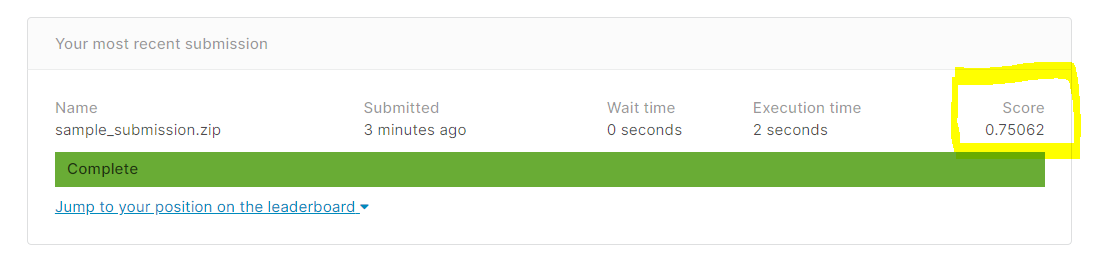

In [ ]:
from textblob import TextBlob

comment_list= \
["==shame on you all!!!== \n\n You want to speak about gays and not about romanians...","what the hell is wrong with u","I love being here","I am going to kill this bastard",
 "fuck this entire post","you are an ignoratn bastard","are you mad","you gay idiot",
 "nigger go die somehere","get your fagget ass out","you are such a weiner pussy","like the new ideas","good things are done"]

for comment in comment_list:
    blob = TextBlob(comment)
    print(comment,"blob score : ", blob.sentiment.polarity, "    model inference: ", classify_toxicity(comment))

Below code is to compare between models between Linear SVC, NaiveBayes, Logistic Regression

Naive Bayes Classifier

model_type = 'naivebayes'

print("Training with a "+model_type+" model")

model_dict_nb= dict()

for category in categories:

    print(" ---------------------------------------- ")
    #print(" Working on evaluating ROC AUC score for "+category+" comments ............")
    
    # the category becomes our predicted variable
    Y= df[category]
    
    # split the data set to a train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
      
    print('Building model for ',category,' comments')
    model = build_model(model_type,1)

    print('Training model...')
    start_time = time.time()
    model.fit(X_train, Y_train)
    elapsed_time = round((time.time() - start_time)/60 , 2)
    print('Training time...{} minutes'.format(elapsed_time))

    print('Evaluating model...')
    print("ROC AUC Score: ",evaluate_model(model, X_test, Y_test))
            
    #save the model into a dictionary
    model_dict_nb[model] = category
    print("Model saved for ",category," comments")
    

Logistic Regression

model_type = 'logistic_reg'

print("Training with a "+model_type+" model")

model_dict_lr= dict()

for category in categories:

    print(" ---------------------------------------- ")
    #print(" Working on evaluating ROC AUC score for "+category+" comments ............")
    
    # the category becomes our predicted variable
    Y= df[category]
    
    # split the data set to a train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
      
    print('Building model for ',category,' comments')
    model = build_model(model_type,1)

    print('Training model...')
    start_time = time.time()
    model.fit(X_train, Y_train)
    elapsed_time = round((time.time() - start_time)/60 , 2)
    print('Training time...{} minutes'.format(elapsed_time))

    print('Evaluating model...')
    print("ROC AUC Score: ",evaluate_model(model, X_test, Y_test))
            
    #save the model into a dictionary
    model_dict_lr[model] = category
    print("Model saved for ",category," comments")
    

Conclusion:

Overall, the Linear SVC model has a better overall score amongst the three models.